# Results

This Python script processes the results of a solution of a stationary convection-diffusion problem in one dimension.

**Version: 03**

- added Peclet numbers to figures;
- removed Peclet numbers from figures;

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from pandas import read_csv

In [2]:
def read_results(path_project, case_name, results_list):
    """ Reads results in the given project and case name. """
    
    # Construct path to the mesh file
    path_mesh = rf"{path_project}\mesher\meshPoints_{case_name}.txt"
    # print(path_mesh)
    
    # Read mesh file
    mesh = read_csv(path_mesh, sep=" ", header=None, skiprows=1)
    mesh = mesh[1].to_numpy()
    # print(mesh)
    
    # Construct path to the results file
    path_solver = rf"{path_project}\solver\results_{case_name}.txt"
    # print(path_solver)
    
    # Read results file
    values = read_csv(path_solver, header=None, skiprows=1)
    values = values[0].to_numpy()
    # print(values)
    
    # Return a list of mesh np.array and results np.array
    results_list.append(mesh)
    results_list.append(values)

    return

In [3]:
def exact_solution(x, phi0=0.0, phiL=1.0, L=1.0, Pe=50):
    """ Returns the exact solution of a steady convection-diffusion problem in one dimension. """

    phi = phi0 + (np.exp(x * Pe / L) - 1.0) / (np.exp(Pe) - 1.0) * (phiL - phi0)

    return phi

In [4]:
def calculate_Pe(resultPe):
    """ Calculates the Peclet number for the supplied mesh.
    
    The mesh is supplied in the resultPe as a np.array in a list.
    The result is appended to the supplied list. """

    path_settings = rf"{path_project}\solver\solverControls.json"
    
    with open(path_settings, mode="r", encoding="utf-8") as f:
        settings = json.load(f)
    
    resultPe.append(np.zeros_like(resultPe[0]))

    for i in range(1, len(resultPe[0])):
        resultPe[1][i] = settings["rho"] * settings["u_init"] * \
                         (resultPe[0][i] - resultPe[0][i-1]) / settings["gamma"]

In [5]:
def plot_results(results, filename="figure.png", withPe=False):
    """ PLots a list of given results in one figure. """

    styles = ['-', 'o--', 'v--', 's--', 'x--']
    
    fig, ax = plt.subplots()
    # fig, ax = plt.subplots(figsize=(5,7.5))

    
    for i, (case_name, result) in enumerate(results.items()):
        if case_name == "Pe":
            break
        ax.plot(result[0], result[1], styles[i], label=case_name)
    
    # if ("Pe" in results):
    #     ax2 = ax.twinx()
    #     ax2.plot(results["Pe"][0], results["Pe"][1], label="Pe")
    #     ax2.set_ylabel("Peclet number")

    # for x, Pe in zip(results["Pe"][0], results["Pe"][1]):
    #     text = f"{Pe:.1f}"
    #     xy = (x, x*1.0)
    #     offset = (0, 0)
    #     ax.annotate(text, xy, xytext=offset, textcoords="offset points", horizontalalignment="center")

    # ax.set_xticks(results["Pe"][0], minor=True)
    # ax.xaxis.grid(True, which='major')
    # ax.xaxis.grid(True, which='minor')

    # Add vertical lines depicting node locations
    for x in results["Pe"][0]:
        ax.axvline(x=x, color='gray', linewidth=0.5)

    # Add Peclter number values as annotations
    # if withPe:
    #     for x, Pe, y in zip(results["Pe"][0], results["Pe"][1], results["UDS_m011_r07"][1]):
    #         text = f"{Pe:.1f}"
    #         xy = (x, y)
    #         offset = (0, 10)
    #         ax.annotate(text, xy, xytext=offset, textcoords="offset points", horizontalalignment="center")

    ax.set_xlabel("x")
    ax.set_ylabel("phi")
    ax.legend()
    # ax.yaxis.grid(True, which='major')

    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

In [6]:
def analyse_results(case_names, filename, printPe=False):
    """ A wrapper for the whole analysis. """

    # Results are stored in a dict where keys are the case names
    # and values are lists of mesh points and corresponding results
    results = dict()
    
    results["exact"] = list()
    
    for case_name in case_names:
        results[case_name] = list()

    # Read results
    for case_name in case_names:
        read_results(path_project, case_name, results[case_name])

    # Construct the analytical solution
    exact_points = np.linspace(0.0, 1.0, 51)
    results["exact"].append(exact_points)
    results["exact"].append(exact_solution(exact_points))

    # Estimate the local Peclet number
    results["Pe"] = list()
    results["Pe"].append(results[case_names[0]][0])
    calculate_Pe(results["Pe"])
    # print(results)

    # Print a table with results and Peclet numbers
    if printPe:
        print("x Pe CDS >//< exact")
        # for x, pe, cds, uds in zip(results["Pe"][0], results["Pe"][1], results[case_names[0]][1], results[case_names[1]][1]):
        for x, pe, cds in zip(results["Pe"][0], results["Pe"][1], results[case_names[0]][1]):
            exact = exact_solution(x)
            delta = ">" if cds >= exact else "<"
            print(f"{x:.2f} & {pe:6.2f} & {cds:10.2e} & {delta} & {exact:10.2e} \\\\")

    # Plot the results
    plot_results(results, filename=filename, withPe=printPe)

In [7]:
# A path to the project folder (without trailing backslash)
path_project = r"F:\myApps\projects\cfd\cfd-codes\st-conv-diff-1d"

x Pe CDS >//< exact
0.00 &   0.00 &   0.00e+00 & > &   0.00e+00 \\
0.10 &   5.00 &  -6.97e-04 & < &   2.84e-20 \\
0.20 &   5.00 &   9.29e-04 & > &   4.25e-18 \\
0.30 &   5.00 &  -2.86e-03 & < &   6.31e-16 \\
0.40 &   5.00 &   5.99e-03 & > &   9.36e-14 \\
0.50 &   5.00 &  -1.47e-02 & < &   1.39e-11 \\
0.60 &   5.00 &   3.35e-02 & > &   2.06e-09 \\
0.70 &   5.00 &  -7.89e-02 & < &   3.06e-07 \\
0.80 &   5.00 &   1.84e-01 & > &   4.54e-05 \\
0.90 &   5.00 &  -4.29e-01 & < &   6.74e-03 \\
1.00 &   5.00 &   1.00e+00 & > &   1.00e+00 \\


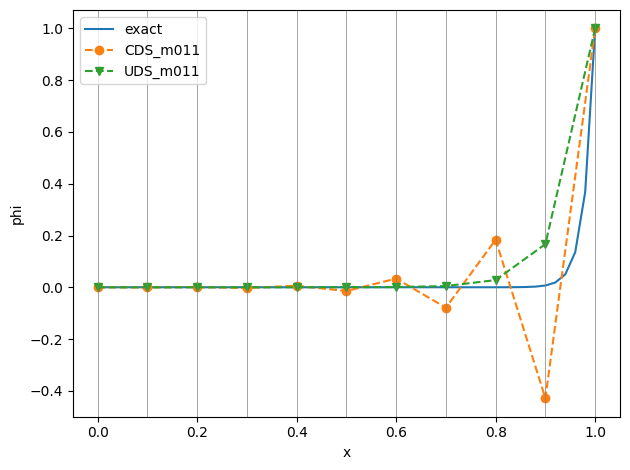

In [8]:
# A list of results-files to process
case_names = [
    r"CDS_m011",
    r"UDS_m011",
]
analyse_results(case_names, "results_m011.png", printPe=True)

x Pe CDS >//< exact
0.00 &   0.00 &   0.00e+00 & > &   0.00e+00 \\
0.02 &   1.00 &   0.00e+00 & < &   3.31e-22 \\
0.04 &   1.00 &   0.00e+00 & < &   1.23e-21 \\
0.06 &   1.00 &   0.00e+00 & < &   3.68e-21 \\
0.08 &   1.00 &   0.00e+00 & < &   1.03e-20 \\
0.10 &   1.00 &   0.00e+00 & < &   2.84e-20 \\
0.12 &   1.00 &   0.00e+00 & < &   7.76e-20 \\
0.14 &   1.00 &   0.00e+00 & < &   2.11e-19 \\
0.16 &   1.00 &   0.00e+00 & < &   5.75e-19 \\
0.18 &   1.00 &   0.00e+00 & < &   1.56e-18 \\
0.20 &   1.00 &   0.00e+00 & < &   4.25e-18 \\
0.22 &   1.00 &   0.00e+00 & < &   1.15e-17 \\
0.24 &   1.00 &   0.00e+00 & < &   3.14e-17 \\
0.26 &   1.00 &   0.00e+00 & < &   8.53e-17 \\
0.28 &   1.00 &   0.00e+00 & < &   2.32e-16 \\
0.30 &   1.00 &   0.00e+00 & < &   6.31e-16 \\
0.32 &   1.00 &   0.00e+00 & < &   1.71e-15 \\
0.34 &   1.00 &   0.00e+00 & < &   4.66e-15 \\
0.36 &   1.00 &   0.00e+00 & < &   1.27e-14 \\
0.38 &   1.00 &   0.00e+00 & < &   3.44e-14 \\
0.40 &   1.00 &   0.00e+00 & < &   9.36e

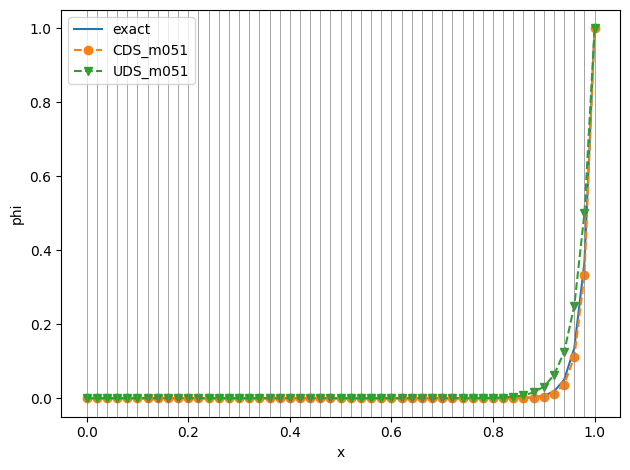

In [9]:
# A list of results-files to process
case_names = [
    r"CDS_m051",
    r"UDS_m051",
]
analyse_results(case_names, "results_m051.png", printPe=True)

x Pe CDS >//< exact
0.00 &   0.00 &   0.00e+00 & > &   0.00e+00 \\
0.31 &  15.44 &  -2.70e-05 & < &   9.75e-16 \\
0.52 &  10.81 &   1.00e-05 & > &   4.81e-11 \\
0.68 &   7.56 &  -5.00e-05 & < &   9.26e-08 \\
0.78 &   5.29 &   7.20e-05 & > &   1.84e-05 \\
0.86 &   3.71 &  -2.92e-04 & < &   7.51e-04 \\
0.91 &   2.59 &   2.15e-03 & < &   1.01e-02 \\
0.94 &   1.82 &   4.49e-02 & < &   6.18e-02 \\
0.97 &   1.27 &   2.02e-01 & < &   2.20e-01 \\
0.99 &   0.89 &   5.25e-01 & < &   5.36e-01 \\
1.00 &   0.62 &   1.00e+00 & > &   1.00e+00 \\


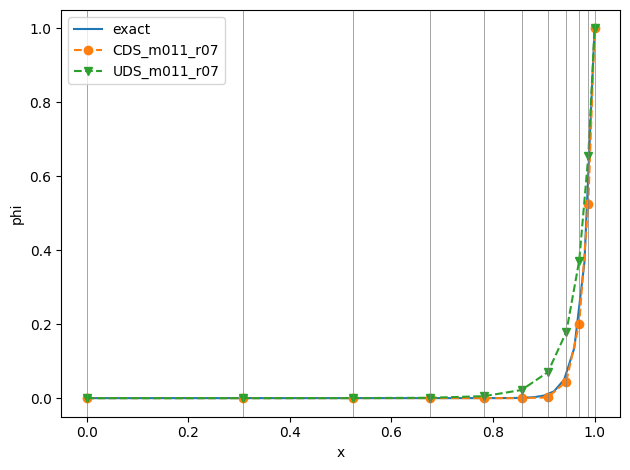

In [10]:
# A list of results-files to process
case_names = [
    r"CDS_m011_r07",
    r"UDS_m011_r07",
]
analyse_results(case_names, "results_m011_r07.png", printPe=True)